<font size=5>Data and Analysis: Finding Agency Inefficiencies within the DEP using Water Complaints</font>

**Importing The Data**

In [162]:
import pandas as pd
import datetime
import numpy
import matplotlib.pyplot as plt

In [163]:
water_data = pd.read_csv("Desktop/water_quality_complaints.csv")

**Initializing the Dataset**

The code below selects only the columns I'm choosing to work with and renaming them for easier use. It also converts some of date columns and creates a new column for the year a complaint was placed. Because further analysis looks into resolution time, a new column is created for that as well. Furthermore, the code limits the data to only rows pertaining to 2010-2017 and for those that aren't missing information. Dropping missing zipcodes wasn't an issue because it made up a small portion of the full DEP data. The closed cases column is left with missing values since there are cases that are still unresolved. 

In [164]:
water_data = water_data[["Created Date","Closed Date", "Status", "Unique Key","Incident Zip","Descriptor"]] #selecting only the columns I need
water_data.columns = ["created", "closed", "status", "comp", "zipcode", "desc"]  #renaming columns for easier use

In [165]:
missing_zip = water_data["zipcode"].isnull().sum()
print("There are {0} zipcodes missing data.".format(missing_zip))

There are 28 zipcodes missing data.


In [166]:
water_data["created"] = pd.to_datetime(water_data["created"])
water_data["closed"] = pd.to_datetime(water_data["closed"])
water_data["year"] = pd.DatetimeIndex(water_data["created"]).year  #creating a new column for year a complaint was placed
water_data["lapsed_time"] = (water_data["closed"] - water_data["created"]).dt.days  #creating a new column for resolution time
water_data = water_data[water_data["year"].between(2010,2017)]
water_data = water_data.dropna(subset=["zipcode"]) #drop all zipcodes that are missing data
water_data["zipcode"] = water_data["zipcode"].astype(int) #convert zipcodes from float to integer to get rid of decimal points
water_data["zipcode"] = water_data["zipcode"].astype(str) #convert zipcodes to text instead of numeric

**How is the number of complaints changing over time?**

Despite the small dip in 2011, there is a general upward trend in the number of water complaints placed per year through the DEP

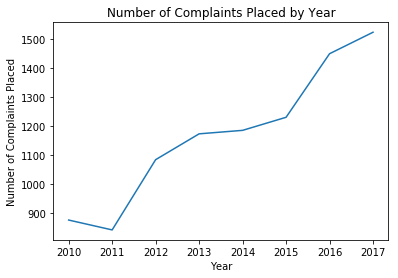

year
2010     876
2011     842
2012    1084
2013    1173
2014    1185
2015    1230
2016    1449
2017    1523
Name: comp, dtype: int64


In [167]:
yearly_data = water_data.groupby(["year"]).count()
yearly_data["comp"].plot()
plt.xlabel("Year")
plt.ylabel("Number of Complaints Placed")
plt.title("Number of Complaints Placed by Year")
plt.show()
print(yearly_data["comp"])

**Is the agency getting better at closing complaints?**

Though there is a dip in closed complaints from 2010 to 2011, the general trend is upward in the number of resolved complaints per year. To put this trend into context, the code below looks at the ratio of unresolved complaints to closed ones by year. At least 98% of all complaints received per year have a closed status. The year 2016 saw the most complaints left unresolved, but those still only made up 1% of all complaints that year, which is negligible. Years 2011, 2013, and 2015 all had 100% rate of closed complaints. From this angle, the DEP is running fairly efficiently. 

In [168]:
yearly_closed_cases = water_data.loc[water_data["status"] == "Closed"].groupby(["year"])
total_yearly_closed_cases = yearly_closed_cases["comp"].count()
yearly_open_cases = water_data.loc[water_data["status"].isin(["Open", "Pending", "Started"])].groupby(["year"])
total_yearly_open_cases = yearly_open_cases["comp"].count()
print(total_yearly_closed_cases)
print(total_yearly_open_cases)

year
2010     874
2011     842
2012    1083
2013    1173
2014    1176
2015    1230
2016    1432
2017    1515
Name: comp, dtype: int64
year
2010     2
2012     1
2014     9
2016    17
2017     8
Name: comp, dtype: int64


In [169]:
total = water_data.groupby(["year"])
total_complaints = total["comp"].count()
perc = (total_yearly_closed_cases/total_complaints)*100
perc = perc.round(2)
print(perc)

year
2010     99.77
2011    100.00
2012     99.91
2013    100.00
2014     99.24
2015    100.00
2016     98.83
2017     99.47
Name: comp, dtype: float64


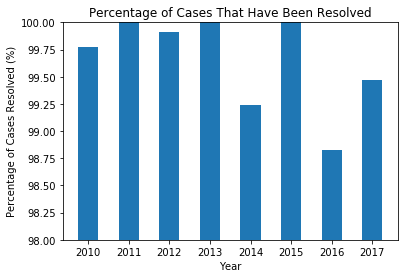

In [170]:
from numpy import arange
fig, ax = plt.subplots()
num_cols = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]
bar_positions = arange(8) + 1
bar_heights = perc.iloc[0:8].values
tick_positions = range(1,9)
ax.bar(bar_positions,bar_heights, 0.5)
ax.set_xticks(tick_positions)
ax.set_ylim([98,100])
ax.set_xticklabels(num_cols)
ax.set_xlabel("Year")
ax.set_ylabel("Percentage of Cases Resolved (%)")
ax.set_title("Percentage of Cases That Have Been Resolved")
plt.show()

**Finding zipcodes with the highest number of open and pending complaints**

The following code sorts the zipcodes with the highest number of unresolved cases. From 2010-2017, this zipcode has been 11374 with three open cases. This zipcode is located in Rego Park of Queens, NY. However, after looking into the portion these unresolved cases make up of all its zipcode's complaints, it only came out to 5%.  Looking into which zipcode historically had the highest percentage of unresolved cases, code below finds that 10% of zipcode 11370's cases are unresolved. Again, this is a misleading statistic since zipcode 11370 has had only ten complaints, one of which is still open. This analysis does not seem to indicate any structural inefficiencies at the DEP.

In [171]:
unresolved_cases = water_data.loc[water_data["status"].isin(["Open", "Pending", "Started"])].groupby(["zipcode"]).count()
unresolved_cases = unresolved_cases["comp"].sort_values(ascending=False)
all_cases = water_data.groupby(["zipcode"]).count()["comp"]
per_cases = (unresolved_cases/all_cases*100).sort_values(ascending=False)
print(per_cases.head(20))
#per_cases = water_data.loc[water_data["zipcode"] == "11374.0", "comp"].count()

zipcode
11370    10.000000
11363     8.695652
11421     7.142857
11436     5.263158
11374     4.918033
11379     4.166667
11217     3.773585
11102     3.125000
11692     2.941176
10011     2.739726
10033     2.500000
11415     2.380952
10302     2.380952
10471     2.083333
10013     2.083333
10021     1.818182
10456     1.694915
10461     1.694915
11206     1.666667
10308     1.515152
Name: comp, dtype: float64


**What is the agency’s average resolution time per year?**

The lapsed time column calculates how many days the DEP took in closing a case. The code below fistly filters any bad data where the lapsed time is a negative value, meaning the closed data came sooner than the date a complaint was placed. It then graphed the average resolution time by year. Taking the average here versus median made more sense since there's enough data points per year to avoid the influence of outliers. Year 2011 saw the most efficient average resolution time of about 17 days. Since 2014, the resolution times has been on the rise which could point to possible inefficency within the DEP. However, earlier findings show that the number of complaints has also been on the rise, so this could be a potential explanation for this. 

In [172]:
water_data = water_data.loc[water_data["lapsed_time"] > 0]
res_time = water_data.groupby(["year"], as_index=False).mean()
print(res_time[["year","lapsed_time"]])

   year  lapsed_time
0  2010    27.519006
1  2011    17.450858
2  2012    18.366022
3  2013    26.635934
4  2014    18.095949
5  2015    22.490690
6  2016    27.554622
7  2017    26.252613


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_color'

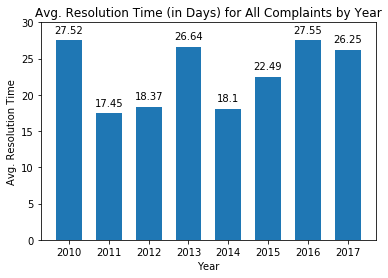

In [179]:
fig, ax = plt.subplots()
num_cols = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]
bar_positions = arange(8) + 1
bar_heights = res_time["lapsed_time"].round(decimals=2)
tick_positions = range(1,9)
ax.bar(bar_positions,bar_heights, 0.65)
ax.set_xticks(tick_positions)
ax.set_xticklabels(num_cols)
ax.set_ylim([0,30])

rects = ax.patches

labels = res_time["lapsed_time"].round(decimals=2).values

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + .75, label,
            ha='center', va='bottom')

plt.xlabel("Year")
plt.ylabel("Avg. Resolution Time")
plt.title("Avg. Resolution Time (in Days) for All Complaints by Year")
plt.show()

**Which zip codes have the longest resolution times?**

Digging further, the code below looks into the median resolution times per zipcode. Median was taken for this analysis since the zipcodes vary widely in the number of complaints/data points each one contains. There are zipcodes in the data that have only one data point so using median would be more accurate here. There are a slew of zipcodes that have a longer resolution time than the median time across all zipcodes. Some zipcodes have resolution times that are at least twice as long than the median. Zipcode 10004, in perticular, has a very high resolution time of 327 days, which seems like an outlier. Having the number of complaints placed per zipcode became helpful to see which zipcodes had enough data to point to a trend. Since the range in number of complaints is from 1-100, a threshold of 50 complaints for a zipcode is a good starting point. Zipcodes 11222, 11231 11230, and 11234 are excellent candidates for zipcodes with enough complaints and a well above median resolution time to warrent an investigation. Moreover, all these zipcodes are in Brooklyn and relatively close to each other. 

In [174]:
all_cases = water_data.groupby(["zipcode"]).count()["comp"]
small = all_cases.min()
large = all_cases.max()
print("The smallest number of complaints for a single zipcode is {0}.".format(small))
print("The maximum number of complaints for a single zipcode is {0}.".format(large))

The smallest number of complaints for a single zipcode is 1.
The maximum number of complaints for a single zipcode is 109.


In [175]:
median = water_data["lapsed_time"].median()
print("Across all zipcodes, the median amount of time that it takes to resolve a complaint is {0} days.".format(median))

Across all zipcodes, the median amount of time that it takes to resolve a complaint is 15.0 days.


In [185]:
water_data["zip_freq"] = water_data.groupby("zipcode")["zipcode"].transform("count") #add the frequency of complaints per zipcode column
mres_time = water_data.groupby(["zipcode"], as_index=False).median()
mres_time = mres_time.sort_values("lapsed_time", ascending=False)
print(mres_time[["zipcode", "lapsed_time", "zip_freq"]].head(25))

    zipcode  lapsed_time  zip_freq
4     10004        327.0       1.0
129   11239         42.0       5.0
48    10303         36.0      27.0
61    10454         35.0      19.0
163   11419         35.0      16.0
86    11040         35.0       1.0
15    10017         30.0       8.0
110   11219         29.0      46.0
145   11369         29.0      16.0
113   11222         28.0      49.0
41    10075         28.0      20.0
165   11421         27.5      16.0
18    10021         27.5      38.0
121   11231         27.0      51.0
120   11230         26.5      62.0
166   11422         26.0      25.0
33    10036         25.5      36.0
124   11234         25.5     100.0
92    11106         25.0      40.0
57    10314         25.0     109.0
53    10308         24.0      51.0
43    10162         24.0       2.0
66    10459         23.5      20.0
135   11358         23.5      42.0
26    10029         23.0      74.0


C:\Users\Sabi015\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


**Does the type of complaint placed affect the resolution time?**

After finding that certain Brooklyn zipcodes have longer resoluation times than the median time across all boroughs, the next analysis involved seeing if this is maybe due to the complaint types. Perhaps there are certain complaints that take a longer time to be resolved due to the nature of the complaint. The following code looks into the average resolution time per complaint type. Concluding from this analysis, complaint type should not have that much of an impact on these zip codes’ high resolution time so there could be other factors at play. 

In [186]:
water_data["desc_freq"] = water_data.groupby("desc")["desc"].transform("count") #add the frequency of diff complaints column
desc = water_data.groupby(["desc"], as_index=False).mean()
desc = desc.sort_values("lapsed_time", ascending=False)
print(desc[["desc","lapsed_time","desc_freq"]])

                                                 desc  lapsed_time  desc_freq
1   Clear Water With Other Particles (Use Comments...    28.580217      829.0
13         unknown odor/taste in drinking water (QA6)    27.201418      705.0
9                          Taste/Odor, Chemical (QA2)    26.010336      774.0
0   Clear Water With Organisms (Insects, Worms) (QE2)    25.955882       68.0
12                            Taste/Odor, Sewer (QA5)    25.156729      587.0
6                          Oil, Grease In Water (QD1)    25.098958      192.0
11                      Taste/Odor, Musty/Stale (QA4)    25.015845      568.0
10                         Taste/Odor, Chlorine (QA1)    24.975689      617.0
8                   Taste/Odor, Bitter/Metallic (QA3)    24.085843      664.0
7            Other Water Problem (Use Comments) (QZZ)    23.693878      245.0
3         Cloudy Or Milky, Other (Use Comments) (QBZ)    22.650873      401.0
2                         Cloudy Or Milky Water (QB1)    15.4972

C:\Users\Sabi015\AppData\Local\Continuum\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


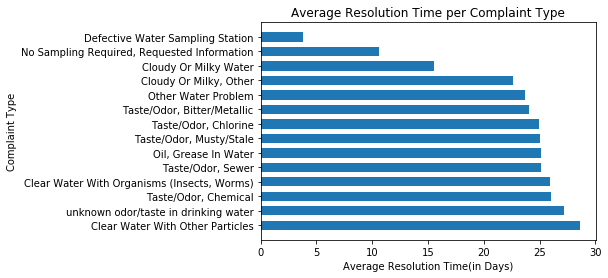

In [191]:
num_cols = ["Clear Water With Other Particles", 
            "unknown odor/taste in drinking water", 
            "Taste/Odor, Chemical",   
            "Clear Water With Organisms (Insects, Worms)", 
            "Taste/Odor, Sewer", 
            "Oil, Grease In Water",
            "Taste/Odor, Musty/Stale", 
            "Taste/Odor, Chlorine",    
            "Taste/Odor, Bitter/Metallic", 
            "Other Water Problem",  
            "Cloudy Or Milky, Other",
            "Cloudy Or Milky Water", 
            "No Sampling Required, Requested Information",  
            "Defective Water Sampling Station"]
fig, ax = plt.subplots()
bar_positions = arange(14) + 1
bar_widths = desc["lapsed_time"].values
tick_positions = range(1,15)
ax.barh(bar_positions,bar_widths, 0.65)
ax.set_yticks(tick_positions)
ax.set_yticklabels(num_cols)
ax.set_xlabel("Average Resolution Time(in Days)")
ax.set_ylabel("Complaint Type")
ax.set_title("Average Resolution Time per Complaint Type")
plt.show()